In [1]:
!pip install monai

     |████████████████████████████████| 721 kB 528 kB/s            


In [2]:
import os
import monai
import torch,torchvision
import skimage
import numpy as np 
import pandas as pd 
from glob import glob
import matplotlib.pyplot as plt
from monai.config import print_config
from monai.utils import first
from monai.config import KeysCollection
from monai.data import Dataset, ArrayDataset, create_test_image_3d, DataLoader
from monai.transforms import (
    Compose,
    AddChanneld,
    LoadImaged,
    Spacingd,
    Resized,
    ScaleIntensityRanged,
    CropForegroundd,
    Resized,
    ToTensor,
    ToTensord,
    Orientationd,
    NormalizeIntensityd,
    RandRotated,
    RandAxisFlipd,
    RandFlipd,
    AdjustContrastd,
)
print_config()


MONAI version: 0.8.1
Numpy version: 1.20.3
Pytorch version: 1.9.1+cpu
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 71ff399a3ea07aef667b23653620a290364095b1

Optional dependencies:
Pytorch Ignite version: 0.4.8
Nibabel version: 3.2.2
scikit-image version: 0.19.1
Pillow version: 8.2.0
Tensorboard version: 2.6.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.10.1+cpu
tqdm version: 4.62.3
lmdb version: 1.3.0
psutil version: 5.8.0
pandas version: 1.3.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: 4.15.0
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [3]:
#We will create two arrays containing file name of Brain MRI and there respective Masks.

# Mask Files
mask_files = sorted(glob('../input/lgg-mri-segmentation/kaggle_3m/*/*_mask*'))

# Brain MRI Images
training_files = []
for path in mask_files:
    training_files.append(path.replace('_mask',''))

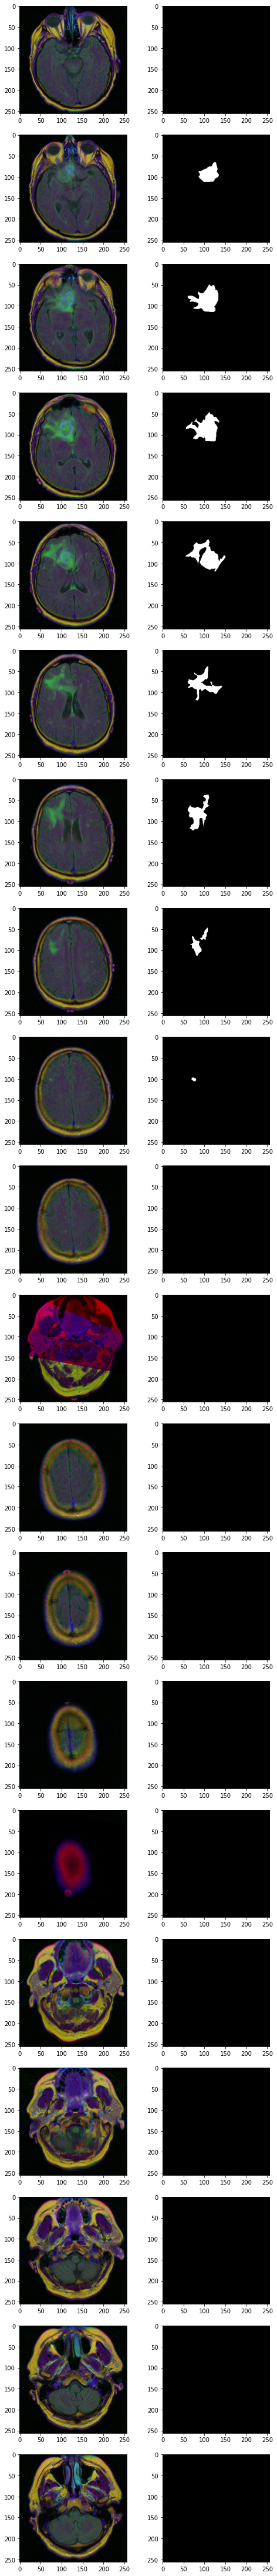

In [4]:
#Visualization of data

rows = 20
fig,ax = plt.subplots(rows,2,figsize=(8,80))
for i in range(rows):
    read1 = plt.imread(training_files[i])
    read2 = plt.imread(mask_files[i])
    ax[i,0].imshow(read1)
    ax[i,1].imshow(read2,cmap='gray')
plt.show()

In [5]:
#So we can see that there are cases in which we dont have masks these cases can lead to difficulty in the learninig of our model.

In [6]:
# will tell us if a image has mask or not
def is_mask(path):
    mask = plt.imread(path)
    if np.max(mask) != 0.0:
        return 1
    else:
        return 0

In [7]:
df = pd.DataFrame({'training_files':training_files,'mask_files':mask_files})
df['mask'] = df['mask_files'].apply(lambda x: is_mask(x))

In [9]:
df.head()

,training_files,mask_files,mask
0,../input/lgg-mri-segmentation/kaggle_3m/TCGA_C...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_C...,0
1,../input/lgg-mri-segmentation/kaggle_3m/TCGA_C...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_C...,1
2,../input/lgg-mri-segmentation/kaggle_3m/TCGA_C...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_C...,1
3,../input/lgg-mri-segmentation/kaggle_3m/TCGA_C...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_C...,1
4,../input/lgg-mri-segmentation/kaggle_3m/TCGA_C...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_C...,1


In [10]:
df['mask'].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

In [12]:
data = df[df['mask']==1]

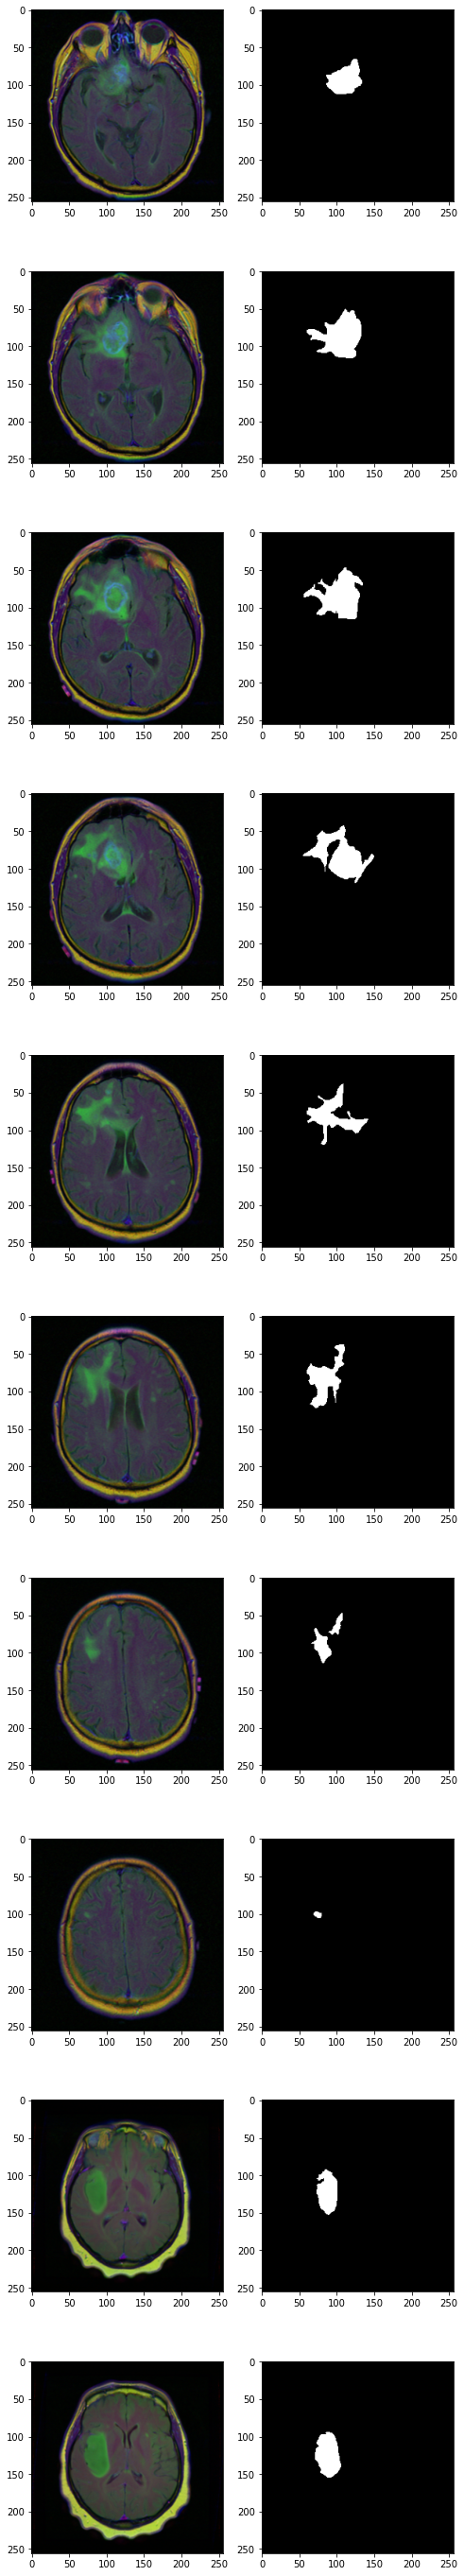

In [13]:
rows = 10
fig,ax = plt.subplots(rows,2,figsize=(8,50))
for i in range(rows):
    read1 = plt.imread(data['training_files'].iloc[i])
    read2 = plt.imread(data['mask_files'].iloc[i])
    ax[i,0].imshow(read1,cmap='gray')
    ax[i,1].imshow(read2,cmap='gray')
plt.show()

Converting the images from .tff to .nii format since it is a very efficient way when using monai or with medical data in general.

Converting the colored images into GrayScale images since It will reduce the model coplexity a lot.

In [14]:
# Creating Dir to store the converted files
dir = './new_data'
mask_out_path = './new_data/mask'
input_out_path = './new_data/input'
os.mkdir(dir)
os.mkdir(mask_out_path)
os.mkdir(input_out_path)

In [16]:
# This library will help in conversion
!pip install imio

In [18]:
from imio import load, save

In [19]:
# Traning Files
for path in data['training_files']:
    img = plt.imread(path)
    img = skimage.color.rgb2gray(img)
    name = os.path.basename(os.path.normpath(path))
    name = os.path.splitext(name)[0]
    save.to_nii(img, "{}/{}.nii.gz".format(input_out_path,name))

In [20]:
# Mask Files
for path in data['mask_files']:
    img = plt.imread(path)
    name = os.path.basename(os.path.normpath(path))
    name = os.path.splitext(name)[0]
    save.to_nii(img, "{}/{}.nii.gz".format(mask_out_path,name))

Preprocessing & Data Augmentation


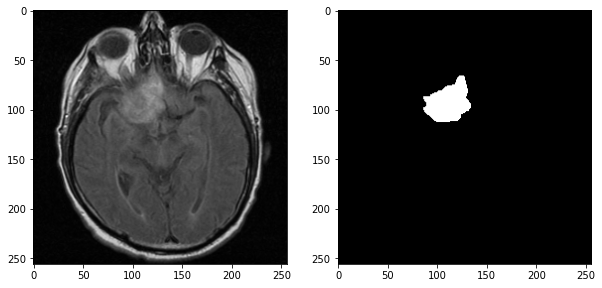

In [21]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
img = skimage.color.rgb2gray(plt.imread(data['training_files'].iloc[0]))
mask = plt.imread(data['mask_files'].iloc[0])
ax[0].imshow(img,cmap='gray')
ax[1].imshow(mask,cmap='gray')

